In [196]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor 

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, f1_score, make_scorer
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from itertools import combinations
from sklearn.impute import SimpleImputer

In [197]:
import seaborn as sns

# Data preparation

In [198]:
train_data = pd.read_csv('aps_failure_training_set.csv')
test_data = pd.read_csv('aps_failure_test_set.csv')

In [199]:
train_data

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,na,2130706438,280,0,0,0,0,0,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,neg,33058,na,0,na,0,0,0,0,0,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,neg,41040,na,228,100,0,0,0,0,0,...,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,neg,12,0,70,66,0,10,0,0,0,...,240,46,58,44,10,0,0,0,4,32
4,neg,60874,na,1368,458,0,0,0,0,0,...,622012,229790,405298,347188,286954,311560,433954,1218,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,neg,153002,na,664,186,0,0,0,0,0,...,998500,566884,1290398,1218244,1019768,717762,898642,28588,0,0
59996,neg,2286,na,2130706538,224,0,0,0,0,0,...,10578,6760,21126,68424,136,0,0,0,0,0
59997,neg,112,0,2130706432,18,0,0,0,0,0,...,792,386,452,144,146,2622,0,0,0,0
59998,neg,80292,na,2130706432,494,0,0,0,0,0,...,699352,222654,347378,225724,194440,165070,802280,388422,0,0


for info, these are the histogram features [ag , ay , az , ba , cn , cs , ee]

### plot

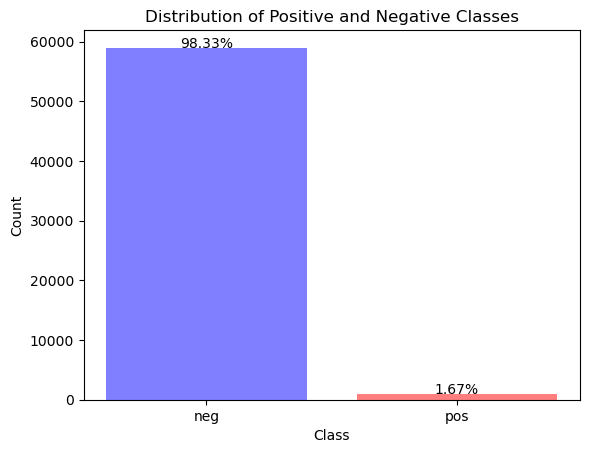

In [200]:
class_counts = train_data['class'].value_counts()

total_samples = len(train_data)
positive_percentage = (class_counts['pos'] / total_samples) * 100
negative_percentage = (class_counts['neg'] / total_samples) * 100

# Plotting
plt.bar(class_counts.index, class_counts.values, color=['blue', 'red'], alpha=0.5)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of Positive and Negative Classes')
plt.text(1, class_counts['pos'], f'{positive_percentage:.2f}%', ha='center')
plt.text(0, class_counts['neg'], f'{negative_percentage:.2f}%', ha='center')
plt.show()

### plot

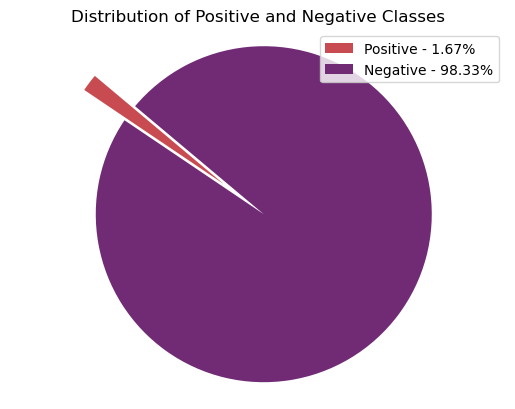

In [201]:
# Plotting
labels = ['Positive - 1.67%', 'Negative - 98.33%']
sizes = [positive_percentage, negative_percentage]
colors = ['#C74B50', '#712B75']
explode = (0.3, 0)  # explode the 1st slice (Positive)

patches, texts = plt.pie(sizes, explode=explode, colors=colors, shadow=False, startangle=140, wedgeprops = {"linewidth": 0, "edgecolor": "white"})
plt.axis('equal')
plt.title('Distribution of Positive and Negative Classes')
plt.legend(labels=labels)
plt.show()

neg -> 0

pos -> 1 : trucks with a problem

In [202]:
train_data = train_data.apply(pd.to_numeric, errors='ignore');
test_data = test_data.apply(pd.to_numeric, errors='ignore');

/var/folders/yj/6cwm4qyj6qz3dkx7t8z3qxc40000gn/T/ipykernel_1648/1030849399.py:1: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  train_data = train_data.apply(pd.to_numeric, errors='ignore');
/var/folders/yj/6cwm4qyj6qz3dkx7t8z3qxc40000gn/T/ipykernel_1648/1030849399.py:2: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  test_data = test_data.apply(pd.to_numeric, errors='ignore');


In [203]:
train_data['class'] = train_data['class'].map({'neg': 0, 'pos': 1})
test_data['class'] = test_data['class'].map({'neg': 0, 'pos': 1})

## missing values: imputing per class

In [204]:
# replace 'na' with np.nan float
train_data.replace('na', np.nan, inplace=True)
test_data.replace('na', np.nan, inplace=True) 

na_counts = train_data.isna().sum()

# drop the features that have too many NA values (more than 35,000)
bad_features = na_counts[na_counts > 35000].index
train_data = train_data.drop(columns=bad_features)
test_data = test_data.drop(columns=bad_features)

# impute
positive_train = train_data[train_data['class'] == 1]
negative_train = train_data[train_data['class'] == 0]

imputer_pos = SimpleImputer(strategy='median')
imputer_neg = SimpleImputer(strategy='median')

# Fit the imputer on the DataFrame and transform the data
positive_train = pd.DataFrame(imputer_pos.fit_transform(positive_train), columns=train_data.columns)
negative_train = pd.DataFrame(imputer_neg.fit_transform(negative_train), columns=train_data.columns)

train_data = pd.concat([positive_train, negative_train])
train_data.reset_index(drop=True, inplace=True)
#==========

# impute
positive_test = test_data[test_data['class'] == 1]
negative_test = test_data[test_data['class'] == 0]

# Fit the imputer on the DataFrame and transform the data
positive_test = pd.DataFrame(imputer_pos.transform(positive_test), columns=train_data.columns)
negative_test = pd.DataFrame(imputer_neg.transform(negative_test), columns=train_data.columns)


test_data = pd.concat([positive_test, negative_test])
test_data.reset_index(drop=True, inplace=True)


In [205]:
train_data.to_csv('out.csv', index=False)

In [206]:
import pipelines as pipe

In [207]:
x_train = train_data.drop(['class'], axis=1)
x_test = test_data.drop(['class'], axis=1)

y_train = train_data['class'].astype(int)
y_test = test_data['class'].astype(int)

# From here we use pipelines

In [208]:
x_train, x_test, y_train, y_test = pipe.pipeline(x_train, x_test, y_train, y_test,
                                                scaler='standard',
                                                imputer='pass',
                                                oversampling='random',
                                                VIF='no')
x_train[0]

array([ 6.45453113e-01, -4.32858719e-01, -4.07463580e-03, -4.13224252e-02,
       -5.13580802e-02, -1.07622955e-02, -2.83695832e-02, -5.69299196e-02,
       -1.00094894e-01,  1.06688322e-01, -2.37768336e-01, -4.16066155e-01,
       -3.49754818e-01, -1.60737781e-01, -2.99784625e-02,  2.02181598e-01,
        3.33470269e-02, -2.25908920e-02, -1.24340521e-02, -5.50407488e-02,
       -5.52124620e-02,  2.69506630e-01,  2.08272838e-01,  1.83673672e-01,
        5.37531728e-01,  2.83254932e-01, -1.14505864e-02, -4.21798742e-02,
       -1.45175435e-02,  4.23389689e-02,  3.42105654e-01, -2.67179846e-02,
       -1.89306909e-02, -2.54787933e-02, -3.48009464e-02, -2.96278176e-02,
       -7.98431865e-02, -3.27529690e-01, -2.83267383e-01, -2.03452401e-02,
       -1.18017734e-02, -1.02950181e-01, -1.29116638e-01, -7.50812233e-02,
       -1.32633906e-01, -3.51050152e-01, -1.81651567e-01, -1.07244383e-02,
       -2.03369352e-02, -4.40927582e-02, -1.28472127e-02, -1.83368484e-01,
       -3.01276148e-01, -

In [209]:
x_train.shape

(118000, 162)

## pca

In [210]:
'''# sample 1000 data points
random_indices = np.random.choice(x_train.shape[0], size=1000, replace=False)
x_train_sampled = x_train[random_indices]
y_train_sampled = y_train[random_indices]

# covariance matrix
cov_matrix = np.cov(x_train_sampled, rowvar=False)
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

n_components = 2
top_eigenvectors = eigenvectors[:, :n_components]

x_train_pca = np.dot(x_train_sampled, top_eigenvectors)

# Plot
plt.figure(figsize=(8, 6))
classes = np.unique(y_train_sampled)
colors = ['r', 'g']

for cls, color in zip(classes, colors):
    idx = np.where(y_train_sampled == cls)
    plt.scatter(x_train_pca[idx, 0], x_train_pca[idx, 1], c=color, label=f'Class {cls}', alpha=0.2)

plt.title('PCA of Training Data (Sampled)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()
'''

"# sample 1000 data points\nrandom_indices = np.random.choice(x_train.shape[0], size=1000, replace=False)\nx_train_sampled = x_train[random_indices]\ny_train_sampled = y_train[random_indices]\n\n# covariance matrix\ncov_matrix = np.cov(x_train_sampled, rowvar=False)\neigenvalues, eigenvectors = np.linalg.eig(cov_matrix)\n\nn_components = 2\ntop_eigenvectors = eigenvectors[:, :n_components]\n\nx_train_pca = np.dot(x_train_sampled, top_eigenvectors)\n\n# Plot\nplt.figure(figsize=(8, 6))\nclasses = np.unique(y_train_sampled)\ncolors = ['r', 'g']\n\nfor cls, color in zip(classes, colors):\n    idx = np.where(y_train_sampled == cls)\n    plt.scatter(x_train_pca[idx, 0], x_train_pca[idx, 1], c=color, label=f'Class {cls}', alpha=0.2)\n\nplt.title('PCA of Training Data (Sampled)')\nplt.xlabel('Principal Component 1')\nplt.ylabel('Principal Component 2')\nplt.legend()\nplt.show()\n"

In [211]:
'''# pca
random_indices = np.random.choice(x_train.shape[0], size=10000, replace=False)
x_train_sampled = x_train[random_indices]
y_train_sampled = y_train[random_indices]

cov_matrix = np.cov(x_train_sampled, rowvar=False)

eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

n_components = 3
top_eigenvectors = eigenvectors[:, :n_components]

x_train_pca = np.dot(x_train_sampled, top_eigenvectors)

#plot
fig = plt.figure(figsize=(15, 5))
angles = [(10, 45), (-40, 170), (10, 10)]
for i, (elev, azim) in enumerate(angles):
    ax = fig.add_subplot(1, 3, i+1, projection='3d')
    ax.set_title(f'PCA of Training Data (Subplot {i+1})')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    
    for cls in np.unique(y_train_sampled):
        idx = np.where(y_train_sampled == cls)
        ax.scatter(x_train_pca[idx, 0], x_train_pca[idx, 1], x_train_pca[idx, 2], label=f'Class {cls}', alpha=0.05)
    ax.view_init(elev=elev, azim=azim)

plt.tight_layout()
plt.show()

# san cone, ta negatives einai mazemena sti myth
'''

"# pca\nrandom_indices = np.random.choice(x_train.shape[0], size=10000, replace=False)\nx_train_sampled = x_train[random_indices]\ny_train_sampled = y_train[random_indices]\n\ncov_matrix = np.cov(x_train_sampled, rowvar=False)\n\neigenvalues, eigenvectors = np.linalg.eig(cov_matrix)\n\nn_components = 3\ntop_eigenvectors = eigenvectors[:, :n_components]\n\nx_train_pca = np.dot(x_train_sampled, top_eigenvectors)\n\n#plot\nfig = plt.figure(figsize=(15, 5))\nangles = [(10, 45), (-40, 170), (10, 10)]\nfor i, (elev, azim) in enumerate(angles):\n    ax = fig.add_subplot(1, 3, i+1, projection='3d')\n    ax.set_title(f'PCA of Training Data (Subplot {i+1})')\n    ax.set_xlabel('Principal Component 1')\n    ax.set_ylabel('Principal Component 2')\n    ax.set_zlabel('Principal Component 3')\n    \n    for cls in np.unique(y_train_sampled):\n        idx = np.where(y_train_sampled == cls)\n        ax.scatter(x_train_pca[idx, 0], x_train_pca[idx, 1], x_train_pca[idx, 2], label=f'Class {cls}', alpha=0.

# Testing models

In [214]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, confusion_matrix, f1_score
import numpy as np

In [215]:
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

## Random Forest

In [216]:
'''
rf = RandomForestClassifier(n_jobs=-1, class_weight={0:1, 1:1.5}, random_state=42)

# hp tuning
param_grid = {
    'max_depth': [5], #[3,5,7,9]
    'n_estimators': [22] #[10,20,22,50]
}
grid_search = GridSearchCV(rf, param_grid, scoring='f1_macro', cv=5)
grid_search.fit(x_train, y_train)

# calculations
y_pred = grid_search.predict(x_test)
conf_m = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_m.ravel()
cost = (10 * fp) + (500 * fn)

# output
print("Best parameters found:", grid_search.best_params_)
print("Best score found:", grid_search.best_score_)
print(f' macro f1 = {f1_score(y_test, y_pred, average="macro")}')
print("Test Cost : ", cost)
print(conf_m)
'''

'\nrf = RandomForestClassifier(n_jobs=-1, class_weight={0:1, 1:1.5}, random_state=42)\n\n# hp tuning\nparam_grid = {\n    \'max_depth\': [5], #[3,5,7,9]\n    \'n_estimators\': [22] #[10,20,22,50]\n}\ngrid_search = GridSearchCV(rf, param_grid, scoring=\'f1_macro\', cv=5)\ngrid_search.fit(x_train, y_train)\n\n# calculations\ny_pred = grid_search.predict(x_test)\nconf_m = confusion_matrix(y_test, y_pred)\ntn, fp, fn, tp = conf_m.ravel()\ncost = (10 * fp) + (500 * fn)\n\n# output\nprint("Best parameters found:", grid_search.best_params_)\nprint("Best score found:", grid_search.best_score_)\nprint(f\' macro f1 = {f1_score(y_test, y_pred, average="macro")}\')\nprint("Test Cost : ", cost)\nprint(conf_m)\n'

In [217]:
'''rf = RandomForestClassifier(n_jobs=-1, class_weight={0:1, 1:1.5}, random_state=42)

# hp tuning
param_grid = {
    'max_depth': [3,5,7,9],
    'n_estimators': [20,22,50] #[10,20,22,50]
}
grid_search = GridSearchCV(rf, param_grid, scoring='f1_macro' , cv=5)
grid_search.fit(x_train, y_train)

# calculations
y_pred = grid_search.predict(x_test)
conf_m = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_m.ravel()
cost = (10 * fp) + (500 * fn)

# output
print("Best parameters found:", grid_search.best_params_)
print("Best score found:", grid_search.best_score_)
print(f' macro f1 = {f1_score(y_test, y_pred, average="macro")}')
print("Test Cost : ", cost)
print(conf_m)
'''

'rf = RandomForestClassifier(n_jobs=-1, class_weight={0:1, 1:1.5}, random_state=42)\n\n# hp tuning\nparam_grid = {\n    \'max_depth\': [3,5,7,9],\n    \'n_estimators\': [20,22,50] #[10,20,22,50]\n}\ngrid_search = GridSearchCV(rf, param_grid, scoring=\'f1_macro\' , cv=5)\ngrid_search.fit(x_train, y_train)\n\n# calculations\ny_pred = grid_search.predict(x_test)\nconf_m = confusion_matrix(y_test, y_pred)\ntn, fp, fn, tp = conf_m.ravel()\ncost = (10 * fp) + (500 * fn)\n\n# output\nprint("Best parameters found:", grid_search.best_params_)\nprint("Best score found:", grid_search.best_score_)\nprint(f\' macro f1 = {f1_score(y_test, y_pred, average="macro")}\')\nprint("Test Cost : ", cost)\nprint(conf_m)\n'

In [218]:
rf = RandomForestClassifier(n_jobs=-1, class_weight={0:1, 1:1.5}, random_state=42)

# hp tuning
param_grid = {
    'max_depth': [7],
    'n_estimators': [22] #[10,20,22,50]
}
grid_search = GridSearchCV(rf, param_grid, scoring='f1_macro' , cv=5)
grid_search.fit(x_train, y_train)

# calculations
y_pred = grid_search.predict(x_test)
conf_m = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_m.ravel()
cost = (10 * fp) + (500 * fn)

# output
print("Best parameters found:", grid_search.best_params_)
print("Best score found:", grid_search.best_score_)
print(f' macro f1 = {f1_score(y_test, y_pred, average="macro")}')
print("Test Cost : ", cost)
print(conf_m)

Best parameters found: {'max_depth': 7, 'n_estimators': 22}
Best score found: 0.9893388595883217
 macro f1 = 0.8860133441109178
Test Cost :  6490
[[15426   199]
 [    9   366]]


In [219]:
rf = RandomForestClassifier(n_jobs=-1, class_weight={0:1, 1:1.5}, random_state=42)

# hp tuning
param_grid = {
    'max_depth': [5],
    'n_estimators': [22] #[10,20,22,50]
}
grid_search = GridSearchCV(rf, param_grid, scoring='f1_macro' , cv=5)
grid_search.fit(x_train, y_train)

# calculations
y_pred = grid_search.predict(x_test)
conf_m = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_m.ravel()
cost = (10 * fp) + (500 * fn)

# output
print("Best parameters found:", grid_search.best_params_)
print("Best score found:", grid_search.best_score_)
print(f' macro f1 = {f1_score(y_test, y_pred, average="macro")}')
print("Test Cost : ", cost)
print(conf_m)

Best parameters found: {'max_depth': 5, 'n_estimators': 22}
Best score found: 0.9820419544771127
 macro f1 = 0.8305634258706581
Test Cost :  6530
[[15272   353]
 [    6   369]]


Best parameters found: {'max_depth': 5, 'n_estimators': 22}
Best score found: 0.9827282746092122
 macro f1 = 0.8412474058133885
Test Cost :  6690
[[15306   319]
 [    7   368]]
(16000,)
(16000,)


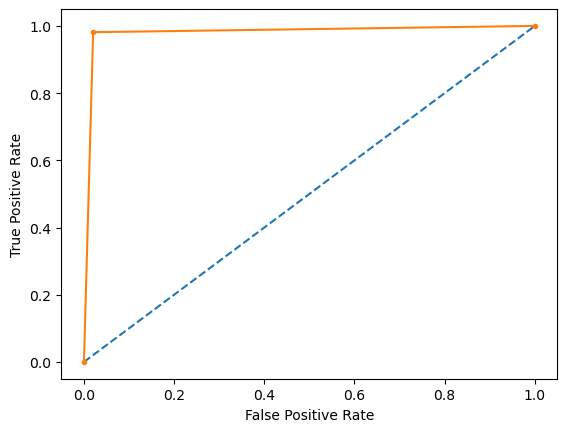

In [220]:
rf = RandomForestClassifier(n_jobs=-1, class_weight={0:1, 1:1.5})

# hp tuning
param_grid = {
    'max_depth': [5],
    'n_estimators': [22] #[10,20,22,50]
}
grid_search = GridSearchCV(rf, param_grid, scoring='f1_macro' , cv=5)
grid_search.fit(x_train, y_train)

# calculations
y_pred = grid_search.predict(x_test)
conf_m = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_m.ravel()
cost = (10 * fp) + (500 * fn)

# output
print("Best parameters found:", grid_search.best_params_)
print("Best score found:", grid_search.best_score_)
print(f' macro f1 = {f1_score(y_test, y_pred, average="macro")}')
print("Test Cost : ", cost)
print(conf_m)

# ROC

# calculate roc curves
print(y_pred.shape)
print(y_test.shape)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# plot the roc curve
plt.plot([0,1], [0,1], linestyle='--', label='')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [221]:
rf = RandomForestClassifier(n_jobs=-1)

# hp tuning
param_grid = {
    'class_weight': [{0:1, 1:1.5}],#, {1:1, 1:1.45}, {1:1, 1:1.55} ],
    'max_depth': [5],
    'n_estimators': [25] #[10,20,22,50]
}
grid_search = GridSearchCV(rf, param_grid, scoring='f1_macro' , cv=5)
grid_search.fit(x_train, y_train)

# calculations
y_pred = grid_search.predict(x_test)
conf_m = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_m.ravel()
cost = (10 * fp) + (500 * fn)

# output
print("Best parameters found:", grid_search.best_params_)
print("Best score found:", grid_search.best_score_)
print(f' macro f1 = {f1_score(y_test, y_pred, average="macro")}')
print("Test Cost : ", cost)
print(conf_m)

Best parameters found: {'class_weight': {0: 1, 1: 1.5}, 'max_depth': 5, 'n_estimators': 25}
Best score found: 0.9819910903494324
 macro f1 = 0.8318314686781387
Test Cost :  6010
[[15274   351]
 [    5   370]]
